In [ ]:
!pip install scikit-posthocs

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from geopy.distance import geodesic
import scipy.stats as stats
from scikit_posthocs import posthoc_dunn
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [ ]:
la_hotel = pd.read_csv('la_hotels.csv')
la_rental = pd.read_csv('la_rentals.csv')
la_yelp = pd.read_csv('la_restaurants_bids.csv')
la_rest_filtered = pd.read_csv('/content/filtered_df_LA.csv')

tn_hotel = pd.read_csv('tn_hotels.csv')
tn_rental = pd.read_csv('tn_rentals.csv')
tn_yelp = pd.read_csv('tn_restaurants_bids.csv')
tn_rest_filtered = pd.read_csv('/content/filtered_reviews_tn.csv')

In [ ]:
la_hotel = la_hotel.drop(columns = ['Description'], axis = 1)
la_hotel.rename(columns = {'Name':'hotel_name'}, inplace = True)
print(la_hotel.head())

la_rental['rental_name'] = [f"rental_{i+1}" for i in range(len(la_rental))]
order = ['rental_name', 'latitude', 'longitude', 'Address', 'zipcode']
la_rental = la_rental[order]
print(la_rental.head())

print(la_yelp.head())

tn_hotel.rename(columns = {'Name':'hotel_name'}, inplace = True)
print(tn_hotel.head())

tn_rental['rental_name'] = [f"rental_{i+1}" for i in range(len(tn_rental))]
order = ['rental_name', 'Latitude', 'Longitude', 'Address', 'zipcode']
tn_rental = tn_rental[order]
print(tn_rental.head())

print(tn_yelp.head())

                               hotel_name   Latitude  Longitude  \
0             Thousand Trails Forest Lake  35.860118 -80.396121   
1  TownePlace Suites New Orleans Metairie  29.964645 -90.191204   
2     Red Roof Inn New Orleans - Westbank  29.895480 -90.088263   
3                   Catahoula New Orleans  29.951846 -90.073213   
4        Garden District Hotel Collection  29.938013 -90.074648   

                                             Address  zipcode  
0  498, Thousand Trails Drive, Davie County, Nort...    27006  
1  TownePlace Suites New Orleans Metairie, 5424, ...    70123  
2  3754, Westbank Expressway, Harvey, Jefferson P...    70058  
3  Perdido Street, Storyville, New Orleans, Orlea...    70112  
4  The Prytania Park Hotel, Terpsichore Street, L...    70130  
  rental_name   latitude  longitude  \
0    rental_1  29.945408 -90.365234   
1    rental_2  29.939131 -90.338715   
2    rental_3  29.966347 -90.298470   
3    rental_4  30.026085 -90.260620   
4    rental_5  29.

In [ ]:
la_rest_filtered = la_rest_filtered.drop(columns = ['review_text'], axis = 1)
la_rest_filtered = la_rest_filtered.drop(columns = ['Sentiment'], axis = 1)
la_rest_filtered = la_rest_filtered.drop_duplicates(subset = ['rest_bid'])

tn_rest_filtered = tn_rest_filtered.drop(columns = ['review_text'], axis = 1)
tn_rest_filtered = tn_rest_filtered.drop_duplicates(subset = ['rest_bid'])
print(la_rest_filtered.head())
la_rest_filtered.info()
print(tn_rest_filtered.head())
tn_rest_filtered.info()

     rest_bid                     rest_name    rest_city  \
0       10219                 Compère Lapin  New Orleans   
56      88916                        Bayona  New Orleans   
90     104393                   The Vintage  New Orleans   
154    126930  Cafe Beignet on Royal Street  New Orleans   
208     31034                   Royal House  New Orleans   

             rest_address  zipcode  rest_latitude  rest_longitude  rest_stars  \
0    535 Tchoupitoulas St    70130        29.9479        -90.0675         4.5   
56        430 Dauphine St    70112        29.9573        -90.0681         4.0   
90       3121 Magazine St    70115        29.9244        -90.0861         4.5   
154          334 Royal St    70130        29.9553        -90.0671         4.0   
208          441 Royal St    70130        29.9565        -90.0664         4.0   

     rest_review_count  
0                  804  
56                 746  
90                 344  
154               2688  
208               5070  
<c

In [ ]:
la_rest_filtered.rename(columns = {'rest_bid':'bid'}, inplace = True)
tn_rest_filtered.rename(columns = {'rest_bid':'bid'}, inplace = True)
print(la_rest_filtered.head())
print(tn_rest_filtered.head())

        bid                     rest_name    rest_city          rest_address  \
0     10219                 Compère Lapin  New Orleans  535 Tchoupitoulas St   
56    88916                        Bayona  New Orleans       430 Dauphine St   
90   104393                   The Vintage  New Orleans      3121 Magazine St   
154  126930  Cafe Beignet on Royal Street  New Orleans          334 Royal St   
208   31034                   Royal House  New Orleans          441 Royal St   

     zipcode  rest_latitude  rest_longitude  rest_stars  rest_review_count  
0      70130        29.9479        -90.0675         4.5                804  
56     70112        29.9573        -90.0681         4.0                746  
90     70115        29.9244        -90.0861         4.5                344  
154    70130        29.9553        -90.0671         4.0               2688  
208    70130        29.9565        -90.0664         4.0               5070  
       bid                             rest_name  rest_ci

In [ ]:
la_rests = la_rest_filtered.merge(la_yelp, on = 'bid', how = 'inner')
tn_rests = tn_rest_filtered.merge(tn_yelp, on = 'bid', how = 'inner')
la_rests = la_rests.rename(columns = {'zipcode_x':'zipcode'})
tn_rests = tn_rests.rename(columns = {'zipcode_x':'zipcode'})

la_rests = la_rests.drop(columns = ['state', 'name', 'city', 'address', 'zipcode_y', 'stars', 'review_count', 'latitude', 'longitude'])
tn_rests = tn_rests.drop(columns = ['state', 'name', 'city', 'address', 'zipcode_y', 'stars', 'review_count'])

la_rests.info()
tn_rests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bid                212 non-null    int64  
 1   rest_name          212 non-null    object 
 2   rest_city          212 non-null    object 
 3   rest_address       212 non-null    object 
 4   zipcode            212 non-null    int64  
 5   rest_latitude      212 non-null    float64
 6   rest_longitude     212 non-null    float64
 7   rest_stars         212 non-null    float64
 8   rest_review_count  212 non-null    int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 15.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bid                96 non-null     int64  
 1   rest_name          96 non-null     object 
 2   rest_c

In [ ]:
# Concat rentals and hotels
la_lodge = np.vstack([la_hotel, la_rental])
tn_lodge = np.vstack([tn_hotel, tn_rental])

la_lodge = pd.DataFrame(la_lodge, columns = ['lodge_name', 'lodge_latitude', 'lodge_longitude', 'lodge_address', 'zipcode'])
tn_lodge = pd.DataFrame(tn_lodge, columns = ['lodge_name', 'lodge_latitude', 'lodge_longitude', 'lodge_address', 'zipcode'])
print(la_lodge.head())
print(tn_lodge.head())

# Merge LA and TN tables
la_merged = pd.merge(la_rests, la_lodge, on = 'zipcode', how = 'inner')
tn_merged = pd.merge(tn_rests, tn_lodge, on = 'zipcode', how = 'inner')
print(la_merged.head())
print(tn_merged.head())


                               lodge_name lodge_latitude lodge_longitude  \
0             Thousand Trails Forest Lake      35.860118      -80.396121   
1  TownePlace Suites New Orleans Metairie      29.964645      -90.191204   
2     Red Roof Inn New Orleans - Westbank       29.89548      -90.088263   
3                   Catahoula New Orleans      29.951846      -90.073213   
4        Garden District Hotel Collection      29.938013      -90.074648   

                                       lodge_address zipcode  
0  498, Thousand Trails Drive, Davie County, Nort...   27006  
1  TownePlace Suites New Orleans Metairie, 5424, ...   70123  
2  3754, Westbank Expressway, Harvey, Jefferson P...   70058  
3  Perdido Street, Storyville, New Orleans, Orlea...   70112  
4  The Prytania Park Hotel, Terpsichore Street, L...   70130  
                                        lodge_name lodge_latitude  \
0                   Lotus Inn and Suites Nashville      36.153732   
1                        Re

In [ ]:
la_merged = la_merged.dropna()

tn_merged = tn_merged.dropna()

la_merged.info()
tn_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4021 entries, 0 to 4020
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bid                4021 non-null   int64  
 1   rest_name          4021 non-null   object 
 2   rest_city          4021 non-null   object 
 3   rest_address       4021 non-null   object 
 4   zipcode            4021 non-null   object 
 5   rest_latitude      4021 non-null   float64
 6   rest_longitude     4021 non-null   float64
 7   rest_stars         4021 non-null   float64
 8   rest_review_count  4021 non-null   int64  
 9   lodge_name         4021 non-null   object 
 10  lodge_latitude     4021 non-null   object 
 11  lodge_longitude    4021 non-null   object 
 12  lodge_address      4021 non-null   object 
dtypes: float64(3), int64(2), object(8)
memory usage: 408.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 727 entries, 0 to 726
Data columns (total 13 columns):
 #  

In [ ]:
# Calculate distances
def distance_calc_la(row):
  rest_coords = (row['rest_latitude'], row['rest_longitude'])
  lodge_coords = (row['lodge_latitude'], row['lodge_longitude'])
  return geodesic(rest_coords, lodge_coords).miles

def distance_calc_tn(row):
  rest_coords = (row['latitude'], row['longitude'])
  lodge_coords = (row['lodge_latitude'], row['lodge_longitude'])
  return geodesic(rest_coords, lodge_coords).miles

la_merged['distance'] = la_merged.apply(distance_calc_la, axis = 1)
tn_merged['distance'] = tn_merged.apply(distance_calc_tn, axis = 1)

print(la_merged.head())
print(tn_merged.head())

     bid      rest_name    rest_city          rest_address zipcode  \
0  10219  Compère Lapin  New Orleans  535 Tchoupitoulas St   70130   
1  10219  Compère Lapin  New Orleans  535 Tchoupitoulas St   70130   
2  10219  Compère Lapin  New Orleans  535 Tchoupitoulas St   70130   
3  10219  Compère Lapin  New Orleans  535 Tchoupitoulas St   70130   
4  10219  Compère Lapin  New Orleans  535 Tchoupitoulas St   70130   

   rest_latitude  rest_longitude  rest_stars  rest_review_count  \
0        29.9479        -90.0675         4.5                804   
1        29.9479        -90.0675         4.5                804   
2        29.9479        -90.0675         4.5                804   
3        29.9479        -90.0675         4.5                804   
4        29.9479        -90.0675         4.5                804   

                                         lodge_name lodge_latitude  \
0                  Garden District Hotel Collection      29.938013   
1                                  T

In [ ]:
# Filter the distances and cities - 3 miles tops, major tourist areas
la_df = la_merged[la_merged['distance'] <= 3]
la = la_df.copy()
la2 = la_df.copy()
la3 = la_df.copy()
la4 = la_df.copy()
la5 = la_df.copy()
la_df = la_df[la_df['rest_city'] == 'New Orleans']
la = la[la['rest_city'] == 'NEW ORLEANS']
la2 = la2[la2['rest_city'] == ' Chalemette']
la3 = la3[la3['rest_city'] == 'Metairie']
la4 = la4[la4['rest_city'] == 'Marrero']
la5 = la5[la5['rest_city'] == 'Gretna']
la_df = np.vstack([la_df, la, la2, la3, la4, la5])

tn_df = tn_merged[tn_merged['distance'] <= 3]
tn = tn_df.copy()
tn2 = tn_df.copy()
tn3 = tn_df.copy()
tn4 = tn_df.copy()
tn_df = tn_df[tn_df['rest_city'] == 'Nashville']
tn = tn[tn['rest_city'] == 'NASHVILLE']
tn2 = tn2[tn2['rest_city'] == 'Nashville-Davidson metropolitan government (balance)']
tn3 = tn3[tn3['rest_city'] == 'Belle Meade']
tn4 = tn4[tn4['rest_city'] == 'East Nashville']
tn_df = np.vstack([tn_df, tn, tn2, tn4, tn3])

In [ ]:
la_df = pd.DataFrame(la_df, columns = ['bid', 'rest_name', 'rest_city', 'rest_address', 'zipcode',
                                       'rest_latitude', 'rest_longitude', 'stars', 'review_count',
                                       'lodge_name', 'lodge_latitude', 'lodge_longitude', 'lodge_address',
                                       'distance'])
tn_df = pd.DataFrame(tn_df, columns = ['bid', 'rest_name', 'rest_city', 'rest_address', 'zipcode',
                                       'stars', 'review_count', 'rest_latitude', 'rest_longitude',
                                       'lodge_name', 'lodge_latitude', 'lodge_longitude', 'lodge_address',
                                       'distance'])
print(la_df.head())
la_df.info()
print(tn_df.head())
tn_df.info()

     bid      rest_name    rest_city          rest_address zipcode  \
0  10219  Compère Lapin  New Orleans  535 Tchoupitoulas St   70130   
1  10219  Compère Lapin  New Orleans  535 Tchoupitoulas St   70130   
2  10219  Compère Lapin  New Orleans  535 Tchoupitoulas St   70130   
3  10219  Compère Lapin  New Orleans  535 Tchoupitoulas St   70130   
4  10219  Compère Lapin  New Orleans  535 Tchoupitoulas St   70130   

  rest_latitude rest_longitude stars review_count  \
0       29.9479       -90.0675   4.5          804   
1       29.9479       -90.0675   4.5          804   
2       29.9479       -90.0675   4.5          804   
3       29.9479       -90.0675   4.5          804   
4       29.9479       -90.0675   4.5          804   

                                         lodge_name lodge_latitude  \
0                  Garden District Hotel Collection      29.938013   
1                                  The Pelham Hotel      29.950994   
2  Blake Hotel New Orleans, BW Signature Collectio

In [ ]:
la_df.to_csv('la_df.csv', index = False)
tn_df.to_csv('tn_df.csv', index = False)

Nondetailed distances

In [ ]:
la_df2 = pd.read_csv('la_df.csv')
tn_df2 = pd.read_csv('tn_df (1).csv')

print(la_df2.head())
print(tn_df2.head())

      bid                         rest_name         city        rest_address  \
0   97600  Fireman Mike's Cafe & Sweet Shop  New Orleans  203 W Harrison Ave   
1   97600  Fireman Mike's Cafe & Sweet Shop  New Orleans  203 W Harrison Ave   
2   97600  Fireman Mike's Cafe & Sweet Shop  New Orleans  203 W Harrison Ave   
3   97600  Fireman Mike's Cafe & Sweet Shop  New Orleans  203 W Harrison Ave   
4  106952                            Nomiya  New Orleans    4226 Magazine St   

   zipcode  rest_latitude  rest_longitude  stars  review_count  \
0    70124        30.0059        -90.1173    4.5            14   
1    70124        30.0059        -90.1173    4.5            14   
2    70124        30.0059        -90.1173    4.5            14   
3    70124        30.0059        -90.1173    4.5            14   
4    70115        29.9208        -90.0998    4.5           258   

                       lodge_name  lodge_latitude  lodge_longitude  \
0                      rental_142       29.979250   

In [ ]:
# Separate into 2 groups
bins = [0, 2, float('inf')]  # Define the bin edges
labels = ['0-2 miles', 'Greater than 2 miles']  # Define labels

# Apply binning to both DataFrames
la_df2['distance_group'] = pd.cut(la_df2['distance'], bins=bins, labels=labels, right=False)
tn_df2['distance_group'] = pd.cut(tn_df2['distance'], bins=bins, labels=labels, right=False)

print(la_df2.head())
print(tn_df2.head())

      bid                         rest_name         city        rest_address  \
0   97600  Fireman Mike's Cafe & Sweet Shop  New Orleans  203 W Harrison Ave   
1   97600  Fireman Mike's Cafe & Sweet Shop  New Orleans  203 W Harrison Ave   
2   97600  Fireman Mike's Cafe & Sweet Shop  New Orleans  203 W Harrison Ave   
3   97600  Fireman Mike's Cafe & Sweet Shop  New Orleans  203 W Harrison Ave   
4  106952                            Nomiya  New Orleans    4226 Magazine St   

   zipcode  rest_latitude  rest_longitude  stars  review_count  \
0    70124        30.0059        -90.1173    4.5            14   
1    70124        30.0059        -90.1173    4.5            14   
2    70124        30.0059        -90.1173    4.5            14   
3    70124        30.0059        -90.1173    4.5            14   
4    70115        29.9208        -90.0998    4.5           258   

                       lodge_name  lodge_latitude  lodge_longitude  \
0                      rental_142       29.979250   

In [ ]:
# Kruskal Wallis Test
stat, p_value = stats.kruskal(
    la_df2[la_df2['distance_group'] == '0-2']['stars'],
    la_df2[la_df2['distance_group'] == 'Greater than 2 miles']['stars']
)
print(f"Kruskal-Wallis test statistic: {stat}, p-value: {p_value}")
if p_value < 0.05:
    print("There is a significant difference in the ratings between the distance groups.")
else:
    print("There is no significant difference in the ratings between the distance groups.")

stat, p_value = stats.kruskal(
    tn_df2[tn_df2['distance_group'] == '0-2']['stars'],
    tn_df2[tn_df2['distance_group'] == 'Greater than 2 miles']['stars']
)
print(f"Kruskal-Wallis test statistic: {stat}, p-value: {p_value}")
if p_value < 0.05:
    print("There is a significant difference in the ratings between the distance groups.")
else:
    print("There is no significant difference in the ratings between the distance groups.")

# Effect size (eta squared)
if p_value < 0.05:
  k = len(la_df2['distance_group'].unique())
  N = len(la_df2)
  eta_squared = (stat - k + 1) / (N-k)
  print(f"Effect size: {eta_squared:.4f}")
  if eta_squared < 0.01:
    print("Small effect")
  elif eta_squared < 0.06:
    print("Medium effect")
  else:
    print("Large effect")

if p_value < 0.05:
  k = len(tn_df2['distance_group'].unique())
  N = len(tn_df2)
  eta_squared = (stat - k + 1) / (N-k)
  print(f"Effect size: {eta_squared:.4f}")
  if eta_squared < 0.01:
    print("Small effect")
  elif eta_squared < 0.06:
    print("Medium effect")
  else:
    print("Large effect")

if p_value < 0.05:
    print("Significant difference found. Performing Dunn's post-hoc test.")
    dunn_results = posthoc_dunn(la_df2, val_col='stars', group_col='distance_group')
    print(dunn_results)

if p_value < 0.05:
    print("Significant difference found. Performing Dunn's post-hoc test.")
    dunn_results = posthoc_dunn(tn_df2, val_col='stars', group_col='distance_group')
    print(dunn_results)

Kruskal-Wallis test statistic: nan, p-value: nan
There is no significant difference in the ratings between the distance groups.
Kruskal-Wallis test statistic: nan, p-value: nan
There is no significant difference in the ratings between the distance groups.


Detailed distances


In [ ]:
# Separate the distances into groups
bins = [0, 0.5, 1, 1.5, 2, float('inf')]
labels = ['0-0.5', '0.5-1', '1-1.5', '1.5-2', 'Greater than 2 miles']
la_df['distance_group'] = pd.cut(la_df['distance'], bins = bins, labels = labels, right = False)
tn_df['distance_group'] = pd.cut(tn_df['distance'], bins = bins, labels = labels, right = False)
print(la_df.head())
print(tn_df.head())

     bid      rest_name    rest_city          rest_address zipcode  \
0  10219  Compère Lapin  New Orleans  535 Tchoupitoulas St   70130   
1  10219  Compère Lapin  New Orleans  535 Tchoupitoulas St   70130   
2  10219  Compère Lapin  New Orleans  535 Tchoupitoulas St   70130   
3  10219  Compère Lapin  New Orleans  535 Tchoupitoulas St   70130   
4  10219  Compère Lapin  New Orleans  535 Tchoupitoulas St   70130   

  rest_latitude rest_longitude stars review_count  \
0       29.9479       -90.0675   4.5          804   
1       29.9479       -90.0675   4.5          804   
2       29.9479       -90.0675   4.5          804   
3       29.9479       -90.0675   4.5          804   
4       29.9479       -90.0675   4.5          804   

                                         lodge_name lodge_latitude  \
0                  Garden District Hotel Collection      29.938013   
1                                  The Pelham Hotel      29.950994   
2  Blake Hotel New Orleans, BW Signature Collectio

In [ ]:
la_df.to_csv('la_distances.csv', index = False)
tn_df.to_csv('tn_distances.csv', index = False)

In [ ]:
# Kruskal Wallis Test
stat, p_value = stats.kruskal(
    la_df[la_df['distance_group'] == '0-0.5']['stars'],
    la_df[la_df['distance_group'] == '0.5-1']['stars'],
    la_df[la_df['distance_group'] == '1-1.5']['stars'],
    la_df[la_df['distance_group'] == '1.5-2']['stars'],
    la_df[la_df['distance_group'] == 'Greater than 2 miles']['stars']
)
print(f"Kruskal-Wallis test statistic: {stat}, p-value: {p_value}")
if p_value < 0.05:
    print("There is a significant difference in the ratings between the distance groups.")
else:
    print("There is no significant difference in the ratings between the distance groups.")

stat, p_value = stats.kruskal(
    tn_df[tn_df['distance_group'] == '0-0.5']['stars'],
    tn_df[tn_df['distance_group'] == '0.5-1']['stars'],
    tn_df[tn_df['distance_group'] == '1-1.5']['stars'],
    tn_df[tn_df['distance_group'] == '1.5-2']['stars'],
    tn_df[tn_df['distance_group'] == 'Greater than 2 miles']['stars']
)
print(f"Kruskal-Wallis test statistic: {stat}, p-value: {p_value}")
if p_value < 0.05:
    print("There is a significant difference in the ratings between the distance groups.")
else:
    print("There is no significant difference in the ratings between the distance groups.")

# Effect size (eta squared)
if p_value < 0.05:
  k = len(la_df['distance_group'].unique())
  N = len(la_df)
  eta_squared = (stat - k + 1) / (N-k)
  print(f"Effect size: {eta_squared:.4f}")
  if eta_squared < 0.01:
    print("Small effect")
  elif eta_squared < 0.06:
    print("Medium effect")
  else:
    print("Large effect")

if p_value < 0.05:
  k = len(tn_df['distance_group'].unique())
  N = len(tn_df)
  eta_squared = (stat - k + 1) / (N-k)
  print(f"Effect size: {eta_squared:.4f}")
  if eta_squared < 0.01:
    print("Small effect")
  elif eta_squared < 0.06:
    print("Medium effect")
  else:
    print("Large effect")

if p_value < 0.05:
    print("Significant difference found. Performing Dunn's post-hoc test.")
    dunn_results = posthoc_dunn(la_df, val_col='stars', group_col='distance_group')
    print(dunn_results)

if p_value < 0.05:
    print("Significant difference found. Performing Dunn's post-hoc test.")
    dunn_results = posthoc_dunn(tn_df, val_col='stars', group_col='distance_group')
    print(dunn_results)

Kruskal-Wallis test statistic: 19.59656764219254, p-value: 0.0005998106085179402
There is a significant difference in the ratings between the distance groups.
Kruskal-Wallis test statistic: 17.502021613127216, p-value: 0.001543597026784451
There is a significant difference in the ratings between the distance groups.
Effect size: 0.0035
Small effect
Effect size: 0.0213
Medium effect
Significant difference found. Performing Dunn's post-hoc test.
                         0-0.5     0.5-1     1-1.5     1.5-2  \
0-0.5                 1.000000  0.001964  0.285815  0.037169   
0.5-1                 0.001964  1.000000  0.076458  0.918455   
1-1.5                 0.285815  0.076458  1.000000  0.225445   
1.5-2                 0.037169  0.918455  0.225445  1.000000   
Greater than 2 miles  0.056062  0.000317  0.013582  0.002065   

                      Greater than 2 miles  
0-0.5                             0.056062  
0.5-1                             0.000317  
1-1.5                           

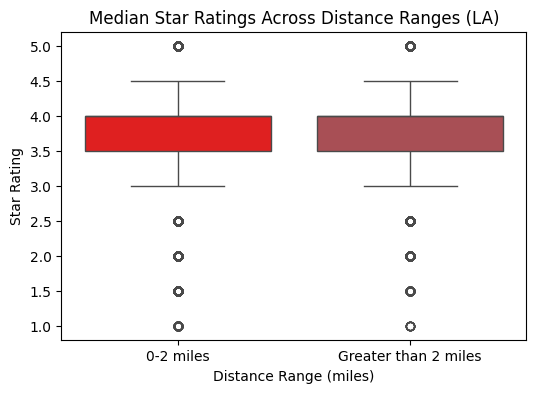

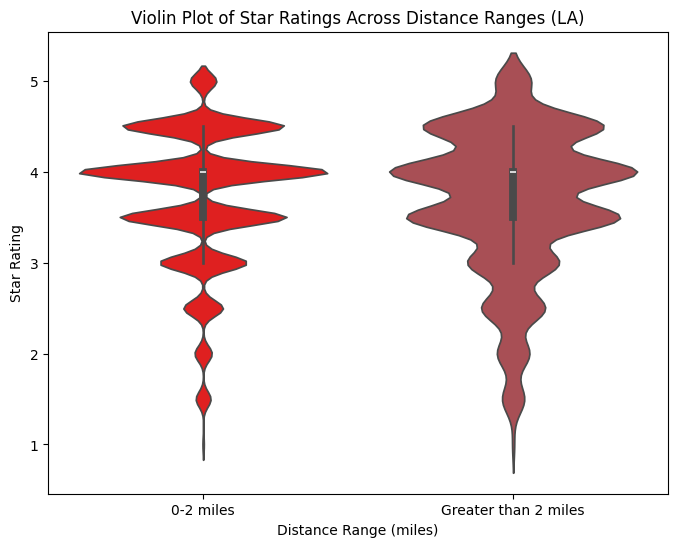

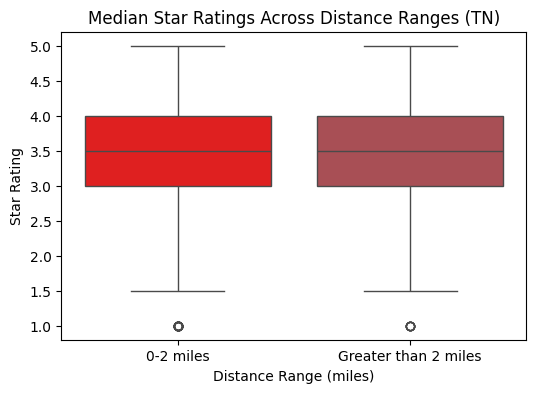

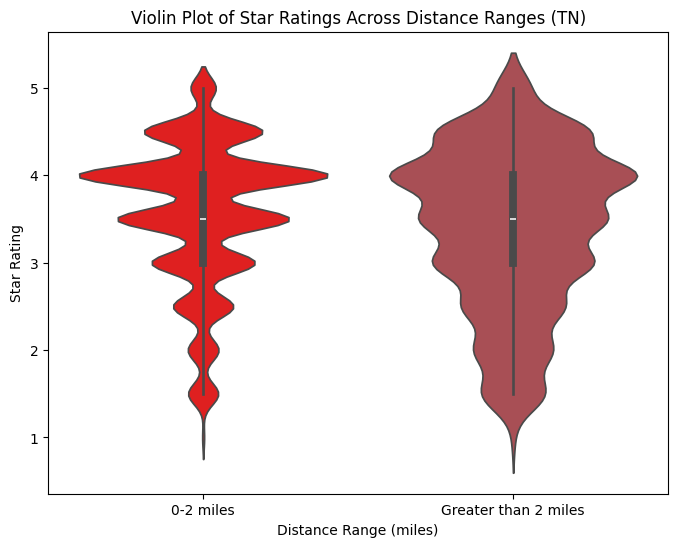

In [ ]:
gradient_palette = sns.color_palette("blend:#FF0000,#708090,#8B0000", n_colors=5)

# Plot the results
plt.figure(figsize=(6, 4))
sns.boxplot(x='distance_group', y='stars', data=la_df, palette = gradient_palette)
plt.title('Median Star Ratings Across Distance Ranges (LA)')
plt.xlabel('Distance Range (miles)')
plt.ylabel('Star Rating')
plt.xticks(rotation=0)
plt.show()

plt.figure(figsize=(8, 6))
sns.violinplot(x='distance_group', y='stars', data=la_df, palette = gradient_palette)
plt.title('Violin Plot of Star Ratings Across Distance Ranges (LA)')
plt.xlabel('Distance Range (miles)')
plt.ylabel('Star Rating')
plt.xticks(rotation=0)
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(x='distance_group', y='stars', data=tn_df, palette = gradient_palette)
plt.title('Median Star Ratings Across Distance Ranges (TN)')
plt.xlabel('Distance Range (miles)')
plt.ylabel('Star Rating')
plt.xticks(rotation=0)
plt.show()

plt.figure(figsize=(8, 6))
sns.violinplot(x='distance_group', y='stars', data=tn_df, palette = gradient_palette)
plt.title('Violin Plot of Star Ratings Across Distance Ranges (TN)')
plt.xlabel('Distance Range (miles)')
plt.ylabel('Star Rating')
plt.xticks(rotation=0)
plt.show()

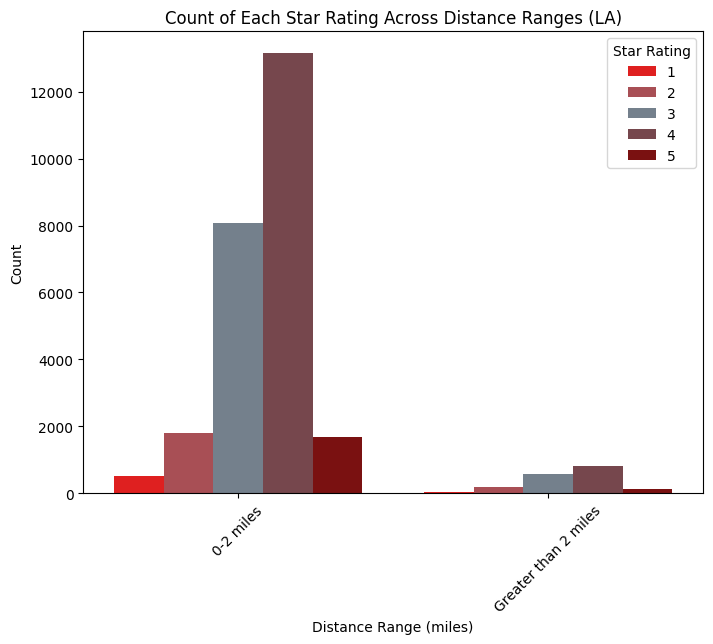

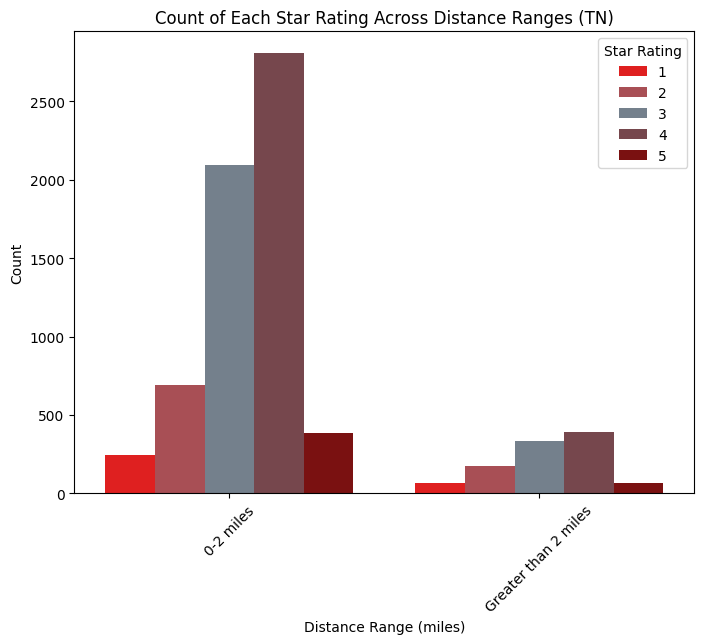

In [ ]:
# Plot of count of each type of star rating
la_count_stars = la_df.groupby(['distance_group', 'stars']).size().reset_index(name='count')
la_count_stars['stars'] = la_count_stars['stars'].astype(float).astype(int)
la_count_stars = la_count_stars[la_count_stars['stars'].isin(range(6))]

tn_count_stars = tn_df.groupby(['distance_group', 'stars']).size().reset_index(name='count')
tn_count_stars['stars'] = tn_count_stars['stars'].astype(float).astype(int)
tn_count_stars = tn_count_stars[tn_count_stars['stars'].isin(range(6))]

plt.figure(figsize=(8, 6))
sns.barplot(x='distance_group', y='count', hue='stars', data=la_count_stars, ci = None, palette = gradient_palette)
plt.title('Count of Each Star Rating Across Distance Ranges (LA)')
plt.xlabel('Distance Range (miles)')
plt.ylabel('Count')
plt.legend(title='Star Rating')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 6))
sns.barplot(x='distance_group', y='count', hue='stars', data=tn_count_stars, ci = None, palette = gradient_palette)
plt.title('Count of Each Star Rating Across Distance Ranges (TN)')
plt.xlabel('Distance Range (miles)')
plt.ylabel('Count')
plt.legend(title='Star Rating')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Convert 'review_count' to numeric, handling errors
la_df['review_count'] = pd.to_numeric(la_df['review_count'], errors='coerce')
tn_df['review_count'] = pd.to_numeric(tn_df['review_count'], errors='coerce')

# Anova on review counts
f_stat, p_value = stats.f_oneway(
    la_df[la_df['distance_group'] == '0-0.5']['review_count'],
    la_df[la_df['distance_group'] == '0.5-1']['review_count'],
    la_df[la_df['distance_group'] == '1-1.5']['review_count'],
    la_df[la_df['distance_group'] == '1.5-2']['review_count'],
    la_df[la_df['distance_group'] == 'Greater than 2 miles']['review_count']
)

print(f"ANOVA F-statistic: {f_stat}, p-value: {p_value}")
if p_value < 0.05:
    print("There is a significant difference in the average review counts between the distance groups.")
else:
    print("There is no significant difference in the average review counts between the distance groups.")

f_stat, p_value = stats.f_oneway(
    tn_df[tn_df['distance_group'] == '0-0.5']['review_count'],
    tn_df[tn_df['distance_group'] == '0.5-1']['review_count'],
    tn_df[tn_df['distance_group'] == '1-1.5']['review_count'],
    tn_df[tn_df['distance_group'] == '1.5-2']['review_count'],
    tn_df[tn_df['distance_group'] == 'Greater than 2 miles']['review_count']
)
print(f"ANOVA F-statistic: {f_stat}, p-value: {p_value}")
if p_value < 0.05:
    print("There is a significant difference in the average review counts between the distance groups.")
else:
    print("There is no significant difference in the average review counts between the distance groups.")

# Effect size (eta squared)
groups_la = [
    la_df[la_df['distance_group'] == '0-0.5']['review_count'],
    la_df[la_df['distance_group'] == '0.5-1']['review_count'],
    la_df[la_df['distance_group'] == '1-1.5']['review_count'],
    la_df[la_df['distance_group'] == '1.5-2']['review_count'],
    la_df[la_df['distance_group'] == 'Greater than 2 miles']['review_count']
]
all_data_la = np.concatenate(groups_la)
grand_mean_la = np.mean(all_data_la)
sst_la = np.sum((all_data_la - grand_mean_la) ** 2)
means_la = [np.mean(group) for group in groups_la]
sizes_la = [len(group) for group in groups_la]
ssb_la = sum(size * (mean - grand_mean_la) ** 2 for size, mean in zip(sizes_la, means_la))
eta_squared_la = ssb_la / sst_la

print(f"Effect Size (η²) for LA: {eta_squared_la}")

groups_tn = [
    tn_df[tn_df['distance_group'] == '0-0.5']['review_count'],
    tn_df[tn_df['distance_group'] == '0.5-1']['review_count'],
    tn_df[tn_df['distance_group'] == '1-1.5']['review_count'],
    tn_df[tn_df['distance_group'] == '1.5-2']['review_count'],
    tn_df[tn_df['distance_group'] == 'Greater than 2 miles']['review_count']
]
all_data_tn = np.concatenate(groups_tn)
grand_mean_tn = np.mean(all_data_tn)
sst_tn = np.sum((all_data_tn - grand_mean_tn) ** 2)
means_tn = [np.mean(group) for group in groups_tn]
sizes_tn = [len(group) for group in groups_tn]
ssb_tn = sum(size * (mean - grand_mean_tn) ** 2 for size, mean in zip(sizes_tn, means_tn))
eta_squared_tn = ssb_tn / sst_tn

print(f"Effect Size (η²) for TN: {eta_squared_tn}")

# Post Hoc test - Tukey's HSD
tukey_results_la = pairwise_tukeyhsd(
    la_df['review_count'],
    la_df['distance_group'],
    alpha=0.05
)
print(tukey_results_la)

tukey_results_tn = pairwise_tukeyhsd(
    tn_df['review_count'],
    tn_df['distance_group'],
    alpha=0.05
)
print(tukey_results_tn)

ANOVA F-statistic: 3.1603748463979864, p-value: 0.013265438611991786
There is a significant difference in the average review counts between the distance groups.
ANOVA F-statistic: 2.3641839786226564, p-value: 0.05180724450543636
There is no significant difference in the average review counts between the distance groups.
Effect Size (η²) for LA: 0.003237556991488488
Effect Size (η²) for TN: 0.014696770406872138
         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
group1        group2        meandiff p-adj    lower    upper   reject
---------------------------------------------------------------------
 0-0.5                0.5-1   12.488 0.9947  -73.1304  98.1063  False
 0-0.5                1-1.5  -0.7982    1.0  -92.6058  91.0095  False
 0-0.5                1.5-2  47.0915 0.8265    -74.05 168.2331  False
 0-0.5 Greater than 2 miles 188.9627 0.0071   35.3522 342.5731   True
 0.5-1                1-1.5 -13.2861 0.9954 -107.5801  81.0079  False
 0.5-1                1.5-

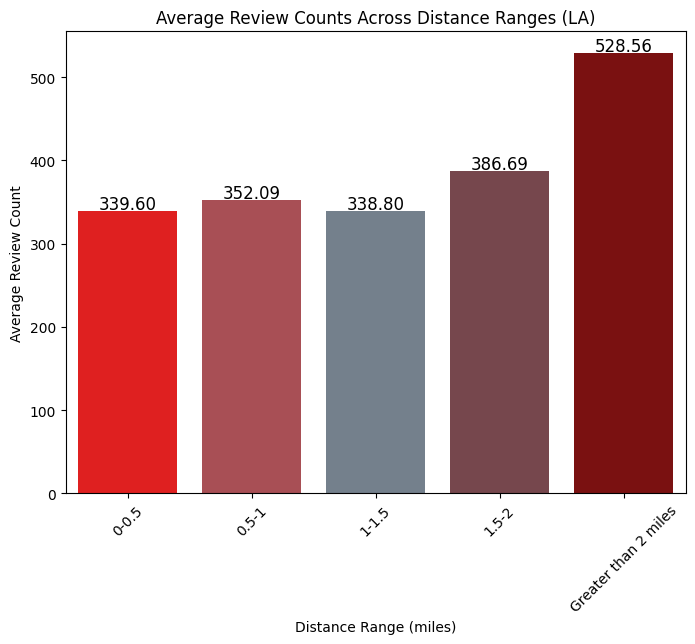

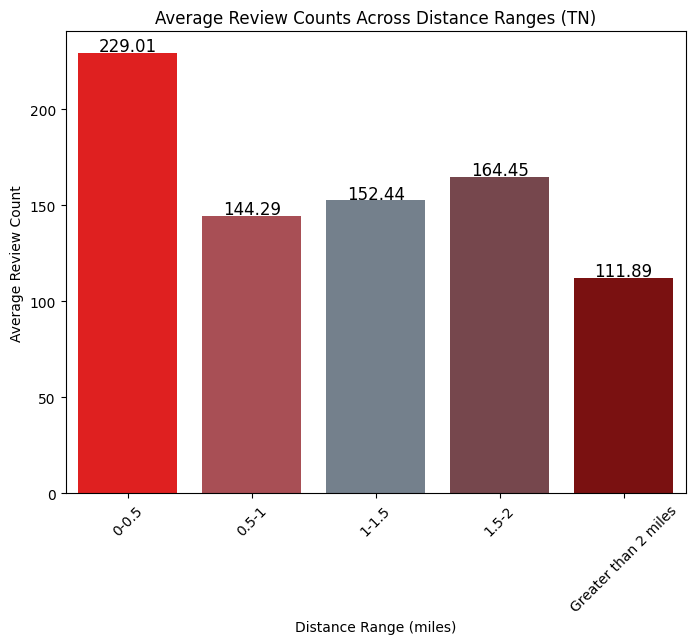

In [ ]:
# plot
mean_review_count = la_df.groupby('distance_group')['review_count'].mean().reset_index()
plt.figure(figsize = (8, 6))
ax = sns.barplot(x='distance_group', y='review_count', data=mean_review_count, palette = gradient_palette)
plt.title('Average Review Counts Across Distance Ranges (LA)')
plt.xlabel('Distance Range (miles)')
plt.ylabel('Average Review Count')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5),
                textcoords='offset points')

plt.xticks(rotation=45)
plt.show()

mean_review_count = tn_df.groupby('distance_group')['review_count'].mean().reset_index()
plt.figure(figsize = (8, 6))
ax = sns.barplot(x='distance_group', y='review_count', data=mean_review_count, palette = gradient_palette)
plt.title('Average Review Counts Across Distance Ranges (TN)')
plt.xlabel('Distance Range (miles)')
plt.ylabel('Average Review Count')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5),
                textcoords='offset points')

plt.xticks(rotation=45)
plt.show()
